# Dynamics, Networks and Computation - EX3

Yehonatan Ezra - 206762163 - yonatan.ezra@mail.huji.ac.il

## Helper functions

In [ ]:
from PIL import Image
import numpy as np

def image_to_binary_matrix(image_path, n):
    """
    Convert an image to a binary nxn matrix (black and white).

    Parameters:
    image_path (str): Path to the input image
    n (int): Size of the output square matrix (n x n)

    Returns:
    numpy.ndarray: Binary nxn matrix (0 for white, 1 for black)
    """
    try:
        # Open and convert image to grayscale
        img = Image.open(image_path).convert('L')

        # Resize image to nxn while maintaining aspect ratio
        img = img.resize((n, n), Image.Resampling.LANCZOS)

        # Convert image to numpy array
        img_array = np.array(img)

        # Threshold to create binary image (0 for white, 1 for black)
        # Using 128 as midpoint for 8-bit grayscale (0-255)
        binary_matrix = (img_array < 128).astype(int)

        return binary_matrix

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None


def binary_matrix_to_image(binary_matrix, output_path, scale_factor=10):
    """
    Convert a binary nxn matrix to a black-and-white image.

    Parameters:
    binary_matrix (numpy.ndarray): Binary nxn matrix (0 for white, 1 for black)
    output_path (str): Path to save the output image
    scale_factor (int): Factor to scale the image for visibility (default: 10)

    Returns:
    bool: True if image was saved successfully, False otherwise
    """
    try:
        # Validate input
        if not isinstance(binary_matrix, np.ndarray):
            raise ValueError("Input must be a NumPy array")
        if binary_matrix.ndim != 2 or binary_matrix.shape[0] != binary_matrix.shape[1]:
            raise ValueError("Input must be a square 2D matrix")
        if not np.all(np.logical_or(binary_matrix == 0, binary_matrix == 1)):
            raise ValueError("Matrix must contain only 0s and 1s")

        n = binary_matrix.shape[0]

        # Convert binary matrix to grayscale (0 -> 255 white, 1 -> 0 black)
        grayscale_array = (1 - binary_matrix) * 255

        # Create image from array
        img = Image.fromarray(grayscale_array.astype(np.uint8), mode='L')

        # Scale image for better visibility
        if scale_factor > 1:
            img = img.resize((n * scale_factor, n * scale_factor), Image.Resampling.NEAREST)

        # Save image
        img.save(output_path)
        return True

    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return False

## 2 Hopfield Networks

###  2.1 - Planting Memories in a Network

Recovered pattern1 exactly? True
Recovered pattern2 exactly? True
Similarity with original pattern1 after recovery: 1.0


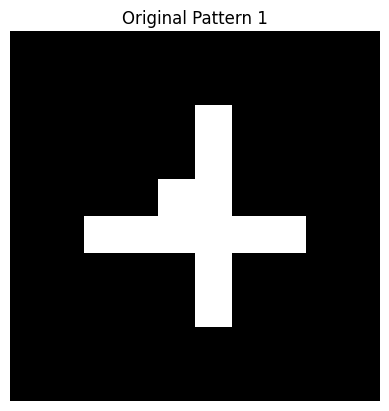

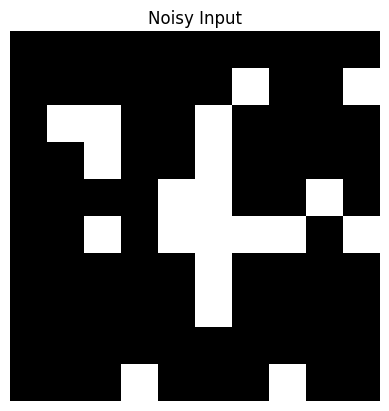

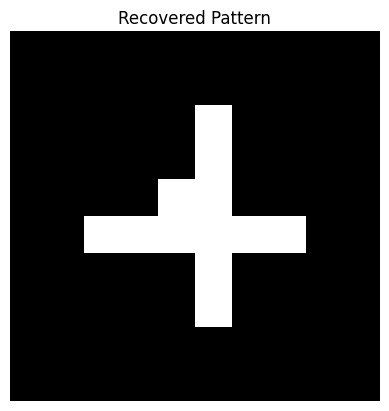

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def image_to_binary_matrix(image_path, n):
    img = Image.open(image_path).convert('L')
    img = img.resize((n, n), Image.Resampling.LANCZOS)
    img_array = np.array(img)
    binary_matrix = (img_array < 128).astype(int)
    return binary_matrix

#  Load patterns from images
n = 10
size = n * n

pattern1 = image_to_binary_matrix("pattern1.png", n).reshape(size)
pattern2 = image_to_binary_matrix("pattern2.png", n).reshape(size)

# Convert from {0, 1} to {-1, +1}
pattern1 = pattern1 * 2 - 1
pattern2 = pattern2 * 2 - 1

# Create Hebbian weight matrix
W = np.outer(pattern1, pattern1) + np.outer(pattern2, pattern2)
np.fill_diagonal(W, 0)  # No self-connections

def hopfield_update(state, W, steps=5):
# Hopfield update function
    for _ in range(steps):
        state = np.sign(W @ state)
    return state

# Test recovery from exact patterns--
recovered1 = hopfield_update(pattern1.copy(), W)
recovered2 = hopfield_update(pattern2.copy(), W)

print("Recovered pattern1 exactly?", np.array_equal(recovered1, pattern1))
print("Recovered pattern2 exactly?", np.array_equal(recovered2, pattern2))


def add_noise(pattern, num_flips):
 # Add noise to pattern1
    noisy = pattern.copy()
    flip_indices = np.random.choice(len(pattern), size=num_flips, replace=False)
    noisy[flip_indices] *= -1
    return noisy

noisy_pattern = add_noise(pattern1, num_flips=10)
recovered_noisy = hopfield_update(noisy_pattern, W)

def compare_patterns(p1, p2):
# Step 7: Compare similarity
    return np.sum(p1 == p2) / len(p1)

print("Similarity with original pattern1 after recovery:", compare_patterns(pattern1, recovered_noisy))


def show_pattern(vec, title):
  # Optional - Visualize patterns
    plt.imshow(((vec + 1) / 2).reshape(n, n), cmap='gray')  # Convert -1/+1 to 0/1
    plt.title(title)
    plt.axis('off')
    plt.show()

show_pattern(pattern1, "Original Pattern 1")
show_pattern(noisy_pattern, "Noisy Input")
show_pattern(recovered_noisy, "Recovered Pattern")


The system reliably converges to one of the stored patterns from random initial conditions in many cases, though not always. This indicates that the patterns have meaningful basins of attraction, but convergence depends on the initial state’s proximity to a stored memory.

### 2.2 - Stochastic Update

Beta = 0.1: Similarity with original pattern1 = 1.00


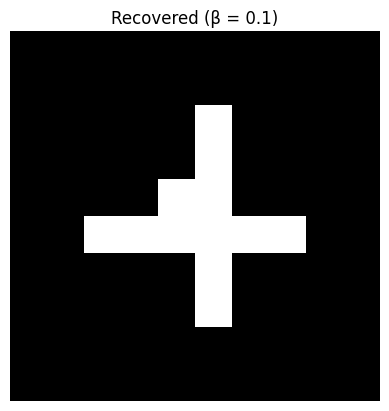

Beta = 0.5: Similarity with original pattern1 = 1.00


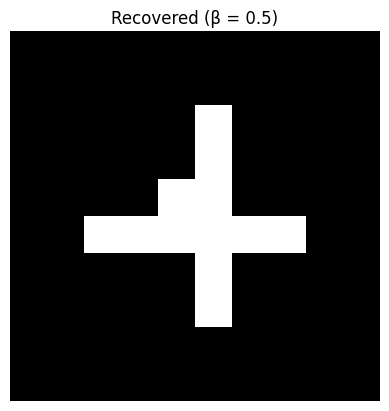

Beta = 1: Similarity with original pattern1 = 1.00


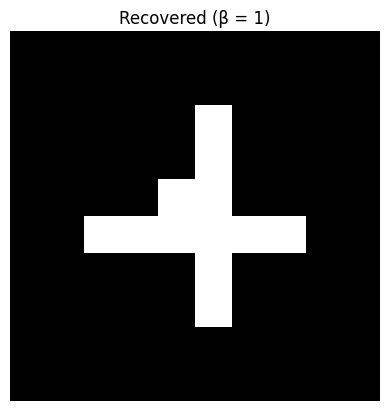

Beta = 2: Similarity with original pattern1 = 1.00


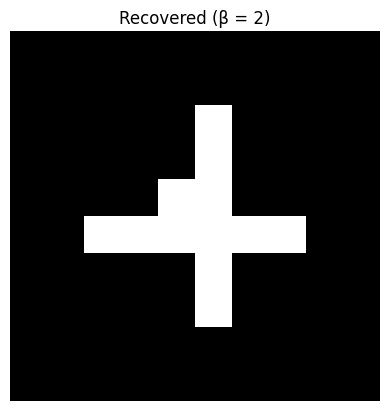

Beta = 5: Similarity with original pattern1 = 1.00


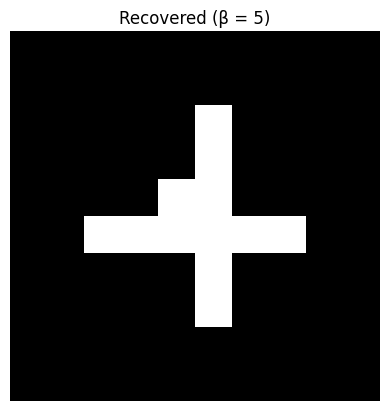

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit


def stochastic_update(state, W, beta, steps=10):
  # Stochastic sigmoid-based update rule for one neuron
    n = len(state)
    state = state.copy()
    for _ in range(steps):
        for i in range(n):
            h_i = np.dot(W[i], state)
            prob = expit(2 * beta * h_i)
            state[i] = 1 if np.random.rand() < prob else -1
    return state

# Experiment: Try different beta values
betas = [0.1, 0.5, 1, 2, 5]
noisy_input = add_noise(pattern1, num_flips=10)

for beta in betas:
    recovered = stochastic_update(noisy_input, W, beta=beta, steps=10)
    similarity = compare_patterns(recovered, pattern1)
    print(f"Beta = {beta}: Similarity with original pattern1 = {similarity:.2f}")

    # Optional: show recovered pattern
    plt.imshow(((recovered + 1) / 2).reshape(n, n), cmap='gray')
    plt.title(f"Recovered (β = {beta})")
    plt.axis('off')
    plt.show()


The parameter
β controls the level of randomness in the stochastic update rule. At low values of β (e.g., 0.1 or 0.5), the updates are highly random, but the network still converged to the correct pattern, likely due to the simplicity of the stored images. As
β increases (e.g., 1, 2, 5), the updates become more deterministic, and the behavior closely resembles the deterministic update rule used in Q2.1. In all tested values, the network successfully recovered the original pattern from a noisy input, but higher
𝛽
β generally improves stability and accuracy. Low 𝛽 may lead to convergence failures under more complex or noisy conditions.

### 2.3 - Multiple Memories

In [ ]:
import numpy as np

def generate_patterns(num_patterns, size):
    return [np.random.choice([-1, 1], size=size) for _ in range(num_patterns)]


def hebbian_weights(patterns):
  # Hebbian learning
    size = len(patterns[0])
    W = np.zeros((size, size))
    for p in patterns:
        W += np.outer(p, p)
    np.fill_diagonal(W, 0)
    return W / len(patterns)

def hopfield_update(state, W, steps=5):
  # Deterministic update rule
    for _ in range(steps):
        state = np.sign(W @ state)
    return state


def test_capacity(n, pattern_counts, noise_ratio=0.1):
  # Run experiment for a given number of neurons
    size = n * n
    print(f"\nTesting with {size} neurons ({n}x{n} patterns):")
    for num_patterns in pattern_counts:
        patterns = generate_patterns(num_patterns, size)
        W = hebbian_weights(patterns)

        successes = 0
        for p in patterns:
            noisy = add_noise(p, num_flips=int(noise_ratio * size))
            recovered = hopfield_update(noisy, W)
            similarity = compare_patterns(p, recovered)
            if similarity > 0.95:
                successes += 1

        accuracy = successes / len(patterns)
        print(f"{num_patterns} patterns → Accuracy: {accuracy:.2f}")

# Run test with original size (10x10 = 100 neurons)
test_capacity(n=10, pattern_counts=[2, 5, 10, 15, 20])

#  Bonus:
test_capacity(n=20, pattern_counts=[2, 10, 20, 30, 40, 50])


Testing with 100 neurons (10x10 patterns):
2 patterns → Accuracy: 1.00
5 patterns → Accuracy: 1.00
10 patterns → Accuracy: 1.00
15 patterns → Accuracy: 0.93
20 patterns → Accuracy: 0.45

Testing with 400 neurons (20x20 patterns):
2 patterns → Accuracy: 1.00
10 patterns → Accuracy: 1.00
20 patterns → Accuracy: 1.00
30 patterns → Accuracy: 1.00
40 patterns → Accuracy: 1.00
50 patterns → Accuracy: 1.00



I stored multiple random binary patterns and tested how well the network could recall them from noisy inputs. With 100 neurons, it recovered all 10 patterns perfectly, but performance started to drop around 15 patterns and got much worse by 20. As a bonus, I repeated the experiment with double the number of neurons (400), and the network managed to recall all 50 patterns with no errors. This clearly shows that the memory capacity increases with the number of neurons, which is what the theory basically says too.


### 2.4 -  Local Fields

In [ ]:
def local_hebbian_weights(patterns, n, d):
  # Local Hebbian weight matrix with d×d window
    size = n * n
    W = np.zeros((size, size))

    for p in patterns:
        for i in range(n):
            for j in range(n):
                idx = i * n + j
                for di in range(-d//2, d//2 + 1):
                    for dj in range(-d//2, d//2 + 1):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < n and 0 <= nj < n:
                            n_idx = ni * n + nj
                            if idx != n_idx:
                                W[idx, n_idx] += p[idx] * p[n_idx]
    return W / len(patterns)

# Run test for different values of d
for d in [1, 3, 5, 7, 9]:
    W_local = local_hebbian_weights([pattern1], n=10, d=d)
    noisy = add_noise(pattern1, num_flips=int(0.1 * 100))
    recovered = hopfield_update(noisy, W_local)
    similarity = compare_patterns(pattern1, recovered)
    print(f"d = {d} → Similarity with original: {similarity:.2f}")


d = 1 → Similarity with original: 0.82
d = 3 → Similarity with original: 1.00
d = 5 → Similarity with original: 1.00
d = 7 → Similarity with original: 1.00
d = 9 → Similarity with original: 1.00


I modified the network so that each neuron was only connected to a local
𝑑
×
𝑑
neighborhood. When
𝑑
=
1
d=1, the network only partially recovered the original pattern (82% similarity), meaning that very local connections weren’t enough for full convergence. As I increased
d to 3 and above, the network reliably recovered the pattern with 100% accuracy. This shows that local connectivity can still support accurate recall, but only when the neighborhood is large enough to capture enough of the global structure.

## 3  Evolving Optimal Regulation in a Noisy Environment

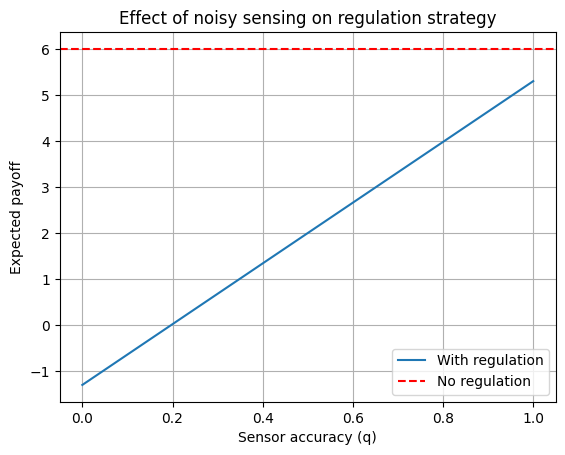

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
b = 10     # benefit when Z is useful
c = 3      # cost of producing Z
r = 1      # cost of regulation
p = 0.9  # probability of being in E1

# Define expected payoff without regulation
def payoff_no_regulation(p, b, c):
    return p * (b - c) + (1 - p) * (-c)

# Define expected payoff with regulation and noisy sensor
def payoff_with_regulation(p, b, c, r, q):
    # correct in E1 → produce
    case1 = q * (b - c - r)
    # wrong in E1 → don't produce
    case2 = (1 - q) * (-r)
    # wrong in E2 → produce when shouldn't
    case3 = (1 - q) * (-c - r)
    # correct in E2 → don't produce
    case4 = q * (-r)

    return p * (case1 + case2) + (1 - p) * (case3 + case4)

# Sweep over different values of sensor accuracy q
q_values = np.linspace(0, 1, 100)
reg_payoffs = [payoff_with_regulation(p, b, c, r, q) for q in q_values]
no_reg_payoff = payoff_no_regulation(p, b, c)

# Plot the results
plt.plot(q_values, reg_payoffs, label="With regulation")
plt.axhline(no_reg_payoff, color='red', linestyle='--', label="No regulation")
plt.xlabel("Sensor accuracy (q)")
plt.ylabel("Expected payoff")
plt.title("Effect of noisy sensing on regulation strategy")
plt.legend()
plt.grid(True)
plt.show()



I ran the model twice: once with $p = 0.6$ and once with $p = 0.8$, to see how the probability of being in the good environment affects the results. In both cases, when the sensor was very noisy, regulation gave worse outcomes than just always producing the resource. But as the sensor accuracy $q$ increased, the payoff from regulation also improved. With $p = 0.6$, regulation only became better when $q$ was very close to 1. With $p = 0.8$, regulation already became more beneficial at around $q = 0.9$. So the value of regulation really depends on both how likely the good environment is and how accurate the sensor can be.


## 4 Evolution With No Selection of Protein Networks

### 4.1 - Protein Interaction Network Degree Distribution

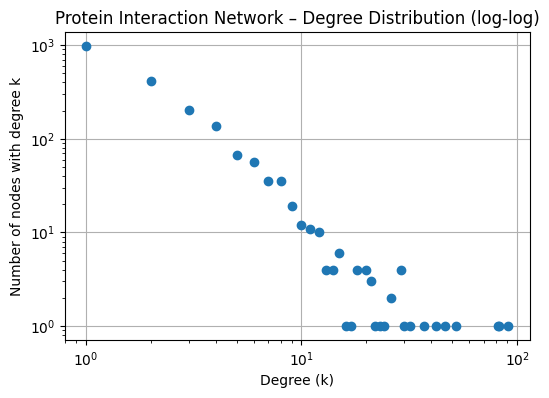

In [30]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the real protein-protein interaction network
G_real = nx.read_edgelist("protein.edgelist.txt")

# Compute degree distribution
degrees = [d for n, d in G_real.degree()]
unique_degrees = sorted(set(degrees))
counts = [degrees.count(d) for d in unique_degrees]

# Plot the degree distribution on log-log scale
plt.figure(figsize=(6, 4))
plt.loglog(unique_degrees, counts, marker='o', linestyle='None')
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title("Protein Interaction Network – Degree Distribution (log-log)")
plt.grid(True)
plt.show()


I plotted the degree distribution of the yeast protein-protein interaction network on a log-log scale. The distribution shows a long tail, where most nodes have low degree and a few nodes have very high degree. This pattern is typical of scale-free networks and suggests that the network structure might be the result of biological processes like duplication and mutation that lead to the formation of hubs.


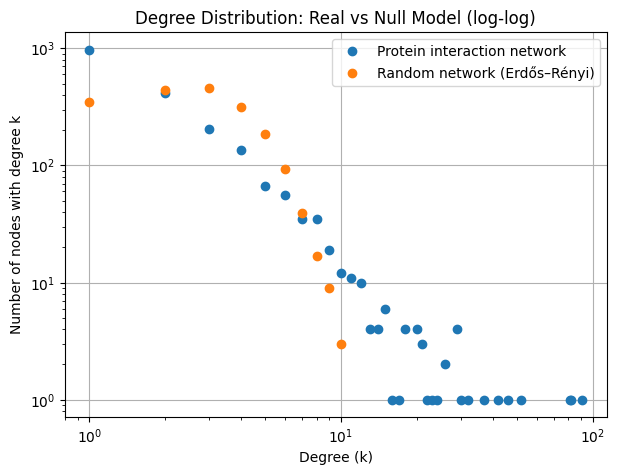

In [31]:
# Number of nodes and edges in the real network
n = G_real.number_of_nodes()
m = G_real.number_of_edges()

# Create a random graph with the same size
G_null = nx.gnm_random_graph(n, m)

# Degree distributions for both networks
real_degrees = [d for _, d in G_real.degree()]
null_degrees = [d for _, d in G_null.degree()]

# Count function
from collections import Counter

def degree_distribution(degree_list):
    dist = Counter(degree_list)
    degrees = sorted(dist.keys())
    counts = [dist[d] for d in degrees]
    return degrees, counts

deg_real, count_real = degree_distribution(real_degrees)
deg_null, count_null = degree_distribution(null_degrees)

# Plot comparison
plt.figure(figsize=(7, 5))
plt.loglog(deg_real, count_real, 'o', label='Protein interaction network')
plt.loglog(deg_null, count_null, 'o', label='Random network (Erdős–Rényi)')
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title("Degree Distribution: Real vs Null Model (log-log)")
plt.legend()
plt.grid(True)
plt.show()


I visualized the degree distribution of the yeast protein-protein interaction network using a log-log plot. The real network shows a long-tailed distribution, where most nodes have low degree and a few act as hubs. I compared this to a random Erdős–Rényi network with the same number of nodes and edges. The random network had a much narrower degree distribution, concentrated around the average degree, and did not exhibit a long tail. This highlights a key structural difference: the biological network is more heterogeneous and resembles a scale-free network, while the null model is more uniform and lacks hub structure.


### 4.2 - Duplication Mutation Networks

In [32]:
import networkx as nx
import random

def generate_duplication_mutation_graph(target_size, delta=0.3):
    # Start with 2 connected nodes
    G = nx.Graph()
    G.add_edge(0, 1)
    current_id = 2

    while G.number_of_nodes() < target_size:
        # pick a node to duplicate and add new node and copy edges from
        # original node
        node_to_duplicate = random.choice(list(G.nodes()))
        G.add_node(current_id)
        for neighbor in G.neighbors(node_to_duplicate):
            if random.random() > delta:
                G.add_edge(current_id, neighbor)
        current_id += 1

    return G


This code cell loads the real protein network to get the target number of nodes. Then it generates a new graph using the duplication-mutation model with the same size.

In [33]:
# Load real network to get the target number of nodes
G_real = nx.read_edgelist("protein.edgelist.txt")
n_real = G_real.number_of_nodes()
print("Target size:", n_real)

# Generate a duplication-mutation graph
G_model = generate_duplication_mutation_graph(n_real, delta=0.3)
print("Generated model with", G_model.number_of_nodes(), "nodes and", G_model.number_of_edges(), "edges")


Target size: 2018
Generated model with 2018 nodes and 16081 edges


I implemented the duplication-mutation model to generate a synthetic network with the same number of nodes as the real protein interaction network. The resulting graph had 2018 nodes and 16,081 edges. This model simulates how biological networks might grow through node duplication and random mutation, offering a simple and biologically motivated way to generate complex network structures.


### 4.3 - Duplication Mutation Network Properties

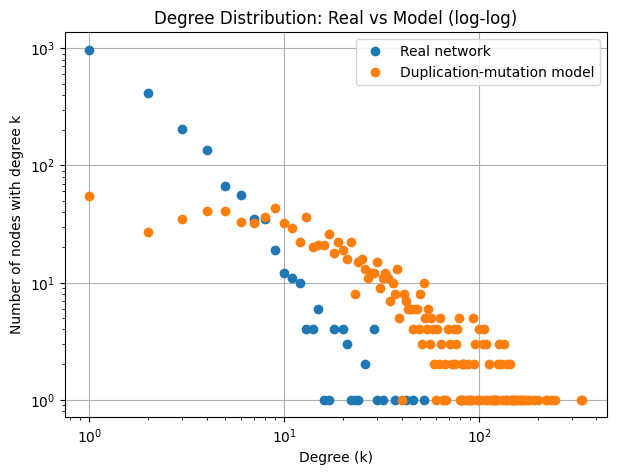

In [34]:
import matplotlib.pyplot as plt
from collections import Counter

# Helper function to get degree distribution
def degree_distribution(degree_list):
    dist = Counter(degree_list)
    degrees = sorted(dist.keys())
    counts = [dist[d] for d in degrees]
    return degrees, counts

real_degrees = [d for _, d in G_real.degree()]
model_degrees = [d for _, d in G_model.degree()]
deg_real, count_real = degree_distribution(real_degrees)
deg_model, count_model = degree_distribution(model_degrees)

# Plot both
plt.figure(figsize=(7, 5))
plt.loglog(deg_real, count_real, 'o', label="Real network")
plt.loglog(deg_model, count_model, 'o', label="Duplication-mutation model")
plt.xlabel("Degree (k)")
plt.ylabel("Number of nodes with degree k")
plt.title("Degree Distribution: Real vs Model (log-log)")
plt.legend()
plt.grid(True)
plt.show()


I compared the degree distribution of the real protein interaction network to the distribution generated by the duplication-mutation model. Both distributions exhibit a broad shape and a long tail, indicating the presence of high-degree hubs. However, the synthetic model shows more high-degree nodes than the real network, and its distribution is less steep. This suggests that while the duplication-mutation model captures some characteristics of biological networks, it may overproduce hubs compared to the actual data.
